# Hybrid Engineering: Physics-Informed ML Calibration
**Author:** Ade Anggi Naluriawan Santoso 
**Objective:** Improve the Standing PVT Correlation by training an ML model to predict and correct its residuals.

**Strategy:**
1.  **Physics:** Calculate $P_b$ using standard industry equations.
2.  **Error Analysis:** Quantify the "Bias" of the equation.
3.  **Hybrid Modeling:** Train a Random Forest to predict the residual error.
4.  **Validation:** Compare Pure Physics vs. Pure ML vs. Hybrid Model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

np.random.seed(42)

# 1. Generate Synthetic Reservoir Data (1000 samples)
n = 1000
temp = np.random.uniform(150, 280, n)      # Temperature (F)
api = np.random.uniform(20, 45, n)         # Oil Gravity (API)
gas_grav = np.random.uniform(0.6, 0.9, n)  # Gas Gravity
rs = np.random.uniform(200, 1200, n)       # Solution GOR

# 2. Simulate "True" Lab Pb using a tweaked Standing equation
# We add a systematic "Reservoir Bias" (e.g., this field is unique) + Random Noise
def true_physics(rs, temp, api, yg):
    # Standard Standing Logic
    a = (rs / yg)**0.83
    b = 0.00091*temp - 0.0125*api
    pb_standing = 18.2 * ((a * 10**b) - 1.4)
    
    # SYSTEMATIC BIAS: Imagine this field has higher asphaltenes affecting Pb
    # The bias depends on API (non-linear)
    bias = 150 + (5000 / api) 
    
    # RANDOM NOISE
    noise = np.random.normal(0, 30, len(rs))
    
    return pb_standing + bias + noise

pb_lab = true_physics(rs, temp, api, gas_grav)

# Create DataFrame
df = pd.DataFrame({
    'Temp_F': temp,
    'API': api,
    'Gas_Grav': gas_grav,
    'Rs': rs,
    'Pb_Lab': pb_lab
})

df.head()

,Temp_F,API,Gas_Grav,Rs,Pb_Lab
0,198.690215,24.628323,0.678512,872.702994,5540.511106
1,273.592860,33.547524,0.674094,996.681397,5539.024030
2,245.159212,41.823646,0.871876,450.467899,1856.424479
3,227.825603,38.305622,0.674864,824.874100,3824.423315
4,170.282423,40.164029,0.681585,771.745983,3039.121756


## 1. Physics Baseline (Standing Correlation)
First, we apply the standard Standing (1947) correlation. This represents the "Traditional Engineering" approach.

In [2]:
def standing_correlation(row):
    # Pb = 18.2 * [ (Rs/Yg)^0.83 * 10^(0.00091T - 0.0125API) - 1.4 ]
    try:
        a = (row['Rs'] / row['Gas_Grav']) ** 0.83
        b = (0.00091 * row['Temp_F']) - (0.0125 * row['API'])
        pb = 18.2 * ((a * (10 ** b)) - 1.4)
        return pb
    except:
        return np.nan

# Apply Physics Model
df['Pb_Standing'] = df.apply(standing_correlation, axis=1)

# Calculate Physics Error
phys_mape = mean_absolute_percentage_error(df['Pb_Lab'], df['Pb_Standing']) * 100
print(f"Physics Baseline MAPE: {phys_mape:.2f}%")

Physics Baseline MAPE: 10.22%


## 2. Residual Analysis
We calculate the **Residual** (The difference between Reality and Physics).
* Positive Residual: Physics underestimated the pressure.
* Negative Residual: Physics overestimated the pressure.

**Goal:** We want to train an ML model to predict this `Residual` column.

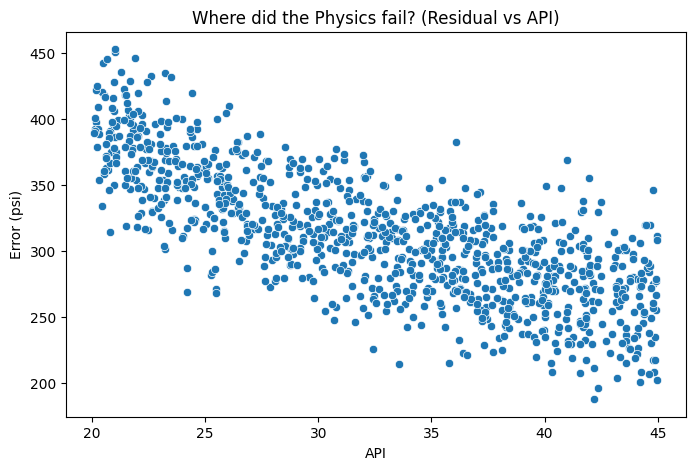

In [3]:
df['Residual'] = df['Pb_Lab'] - df['Pb_Standing']

# Visualize the error structure
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['API'], y=df['Residual'])
plt.title("Where did the Physics fail? (Residual vs API)")
plt.ylabel("Error (psi)")
plt.show()

## 3. Train Hybrid Model (Residual Correction)
We split the data and train a Random Forest model.
* **Inputs:** Temp, API, Gas Gravity, Rs
* **Target:** `Residual` (NOT the full Pb!)

In [4]:
# Features for ML
X = df[['Temp_F', 'API', 'Gas_Grav', 'Rs']]
y_residual = df['Residual']

# Split Data
X_train, X_test, y_train_res, y_test_res = train_test_split(X, y_residual, test_size=0.2, random_state=42)

# Train ML on Residuals
rf_residual = RandomForestRegressor(n_estimators=100, random_state=42)
rf_residual.fit(X_train, y_train_res)

print("Hybrid Model Trained.")

Hybrid Model Trained.


## 4. Final Predictions & Benchmarking
Now we construct the Hybrid Prediction:
$$P_{Hybrid} = P_{Standing} + P_{ML\_Residual}$$

We will compare:
1.  **Standing (Physics)**
2.  **Hybrid (Physics + ML)**

In [5]:
# 1. Get Physics Prediction for Test Set
test_indices = X_test.index
pb_physics_test = df.loc[test_indices, 'Pb_Standing']
pb_lab_test = df.loc[test_indices, 'Pb_Lab']

# 2. Get ML Residual Prediction
pred_residuals = rf_residual.predict(X_test)

# 3. Combine (Hybrid)
pb_hybrid_test = pb_physics_test + pred_residuals

# 4. Calculate Metrics
def get_metrics(y_true, y_pred, name):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"--- {name} ---")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f} psi\n")

get_metrics(pb_lab_test, pb_physics_test, "Pure Physics (Standing)")
get_metrics(pb_lab_test, pb_hybrid_test, "Hybrid (Standing + ML)")

--- Pure Physics (Standing) ---
MAPE: 9.86%
RMSE: 317.75 psi

--- Hybrid (Standing + ML) ---
MAPE: 0.91%
RMSE: 33.80 psi



## 5. Visualization of Success
Visualizing how the Hybrid model "pulls" the predictions back to the 1:1 line.

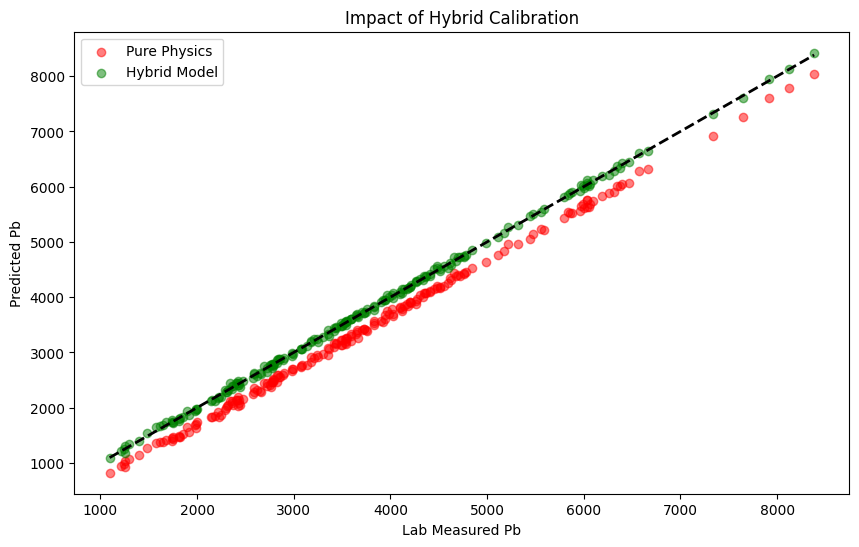

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(pb_lab_test, pb_physics_test, alpha=0.5, label='Pure Physics', color='red')
plt.scatter(pb_lab_test, pb_hybrid_test, alpha=0.5, label='Hybrid Model', color='green')

# Perfect Line
min_val, max_val = pb_lab_test.min(), pb_lab_test.max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.title("Impact of Hybrid Calibration")
plt.xlabel("Lab Measured Pb")
plt.ylabel("Predicted Pb")
plt.legend()
plt.show()